## 机器学习基础练习 7 - K-means 和PCA

### 在本次作业中，我们将进行K-means聚类和PCA降维的练习，并使用它们来压缩图像。
* 我们将从一个简单的2D数据集开始，以了解K-means是如何工作的，然后我们将其应用于图像压缩。 
* 我们还将对PCA降维进行实验，了解如何使用它来找到人脸图像的低维表示。

### 1. K-means 聚类

为了可视化方便，我们将实施和应用K-means到一个简单的二维数据集，以获得工作原理的直观理解。K-means是一个迭代的，无监督的聚类算法，将类别相近的样本组合成簇。该算法从猜测每个簇的初始聚类中心开始，然后重复将样本分配给最近的簇，并重新计算该簇的聚类中心。

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat

我们首先要实现的是找到数据中每个实例最接近的聚类中心的函数，已为大家准备好了。

In [73]:
def find_closest_centroids(X, centroids):
    m = X.shape[0]
    k = centroids.shape[0]
    idx = np.zeros(m)
    
    for i in range(m):
        min_dist = 1000000
        for j in range(k):
            dist = np.sum((X[i,:] - centroids[j,:]) ** 2)
            if dist < min_dist:
                min_dist = dist
                idx[i] = j
    
    return idx

让我们来测试这个函数，以确保它的工作正常。 我们将使用练习中提供的测试用例。

In [74]:
data = loadmat('data/ex7data2.mat')
X = data['X']
initial_centroids = initial_centroids = np.array([[3, 3], [6, 2], [8, 5]])

idx = find_closest_centroids(X, initial_centroids)
idx[0:3]

array([0., 2., 1.])

输出与文本中的预期值匹配（记住我们的数组是从0开始索引的，而不是从1开始索引）。 
接下来，我们需要一个函数来计算簇的聚类中心。聚类中心只是当前分配给簇的所有样本的平均值。

In [75]:
data2 = pd.DataFrame(data.get('X'), columns=['X1', 'X2'])
data2.head()

,X1,X2
0,1.842080,4.607572
1,5.658583,4.799964
2,6.352579,3.290854
3,2.904017,4.612204
4,3.231979,4.939894


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


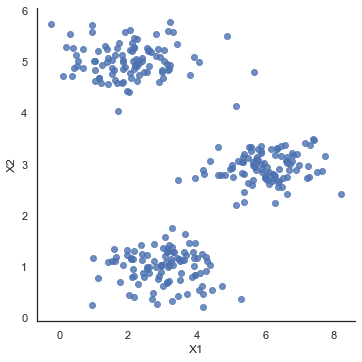

In [76]:
sb.set(context="notebook", style="white")
sb.lmplot('X1', 'X2', data=data2, fit_reg=False)
plt.show()

In [77]:
def compute_centroids(X, idx, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    
    for i in range(k):
        indices = np.where(idx == i)
        centroids[i,:] = (np.sum(X[indices,:], axis=1) / len(indices[0])).ravel()
    
    return centroids

In [78]:
compute_centroids(X, idx, 3)

array([[2.42830111, 3.15792418],
       [5.81350331, 2.63365645],
       [7.11938687, 3.6166844 ]])

此输出也符合练习中的预期值。 
下一部分涉及实际运行该算法的一些迭代次数和可视化结果。 
这个步骤是由于并不复杂，我将从头开始构建它。 为了运行算法，我们只需要在将样本分配给最近的簇并重新计算簇的聚类中心。

In [82]:
def run_k_means(X, initial_centroids, max_iters):
    m, n = X.shape
    k = initial_centroids.shape[0]
    idx = np.zeros(m)
    centroids = initial_centroids
    
    for i in range(max_iters):
        # YOUR_CODE_BEGIN, 请补充两行代码
        idx = find_closest_centroids(X, centroids)
        centroids = compute_centroids(X, idx, k)
        # YOUR_CODE_END
    return idx, centroids

In [83]:
idx, centroids = run_k_means(X, initial_centroids, 10)

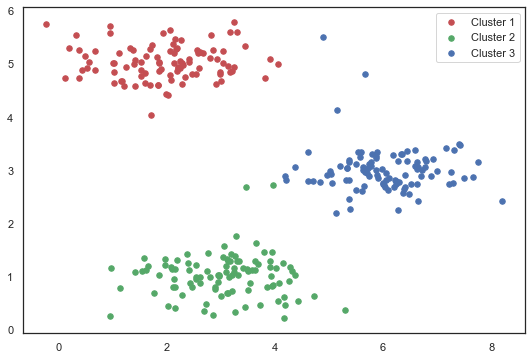

In [84]:
cluster1 = X[np.where(idx == 0)[0],:]
cluster2 = X[np.where(idx == 1)[0],:]
cluster3 = X[np.where(idx == 2)[0],:]

fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(cluster1[:,0], cluster1[:,1], s=30, color='r', label='Cluster 1')
ax.scatter(cluster2[:,0], cluster2[:,1], s=30, color='g', label='Cluster 2')
ax.scatter(cluster3[:,0], cluster3[:,1], s=30, color='b', label='Cluster 3')
ax.legend()
plt.show()

我们跳过的一个步骤是初始化聚类中心的过程，这会影响算法的收敛效果。
接下来，让我们实现这个选择随机样本并将其用作初始聚类中心的函数。

In [85]:
def init_centroids(X, k):
    m, n = X.shape
    centroids = np.zeros((k, n))
    idx = np.random.randint(0, m, k)
    
    for i in range(k):
        # YOUR_CODE_BEGIN, 请补充一行代码
        centroids[i,:] = X[idx[i]]
        # YOUR_CODE_END
    
    return centroids

In [86]:
init_centroids(X, 3)

array([[4.18450011, 0.45356203],
       [3.50663521, 0.73878104],
       [4.08164951, 0.87200343]])

我们的下一个任务是将K-means应用于图像压缩。 
在下面的练习中，我们可以使用聚类来找到最具代表性的少数颜色，并使用聚类分配将原始的24位颜色映射到较低维的颜色空间。 

下面是我们要压缩的图像。

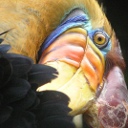

In [93]:
from IPython.display import Image
Image(filename='data/bird_small.png')

The raw pixel data has been pre-loaded for us so let's pull it in.

In [94]:
image_data = loadmat('data/bird_small.mat')
image_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Tue Jun  5 04:06:24 2012',
 '__version__': '1.0',
 '__globals__': [],
 'A': array([[[219, 180, 103],
         [230, 185, 116],
         [226, 186, 110],
         ...,
         [ 14,  15,  13],
         [ 13,  15,  12],
         [ 12,  14,  12]],
 
        [[230, 193, 119],
         [224, 192, 120],
         [226, 192, 124],
         ...,
         [ 16,  16,  13],
         [ 14,  15,  10],
         [ 11,  14,   9]],
 
        [[228, 191, 123],
         [228, 191, 121],
         [220, 185, 118],
         ...,
         [ 14,  16,  13],
         [ 13,  13,  11],
         [ 11,  15,  10]],
 
        ...,
 
        [[ 15,  18,  16],
         [ 18,  21,  18],
         [ 18,  19,  16],
         ...,
         [ 81,  45,  45],
         [ 70,  43,  35],
         [ 72,  51,  43]],
 
        [[ 16,  17,  17],
         [ 17,  18,  19],
         [ 20,  19,  20],
         ...,
         [ 80,  38,  40],
         [ 68,  39,  40],
     

In [95]:
A = image_data['A']
A.shape

(128, 128, 3)

现在我们需要对数据应用一些预处理，并将其提供给K-means算法。

In [96]:
# normalize value ranges
A = A / 255.

# reshape the array
X = np.reshape(A, (A.shape[0] * A.shape[1], A.shape[2]))
X.shape

(16384, 3)

In [97]:
# randomly initialize the centroids
initial_centroids = init_centroids(X, 16)

# run the algorithm
idx, centroids = run_k_means(X, initial_centroids, 10)

# get the closest centroids one last time
idx = find_closest_centroids(X, centroids)

# map each pixel to the centroid value
X_recovered = centroids[idx.astype(int),:]
X_recovered.shape

(16384, 3)

In [98]:
# reshape to the original dimensions
X_recovered = np.reshape(X_recovered, (A.shape[0], A.shape[1], A.shape[2]))
X_recovered.shape

(128, 128, 3)

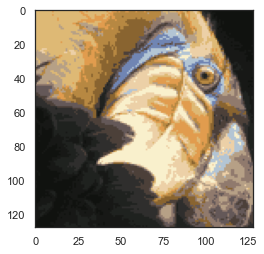

In [99]:
plt.imshow(X_recovered)
plt.show()

您可以看到我们对图像进行了压缩，但图像的主要特征仍然存在。这就是K-means。

下面我们来用scikit-learn来实现K-means。

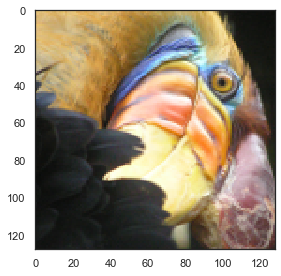

In [100]:
from skimage import io

# cast to float, you need to do this otherwise the color would be weird after clustring
pic = io.imread('data/bird_small.png') / 255.
io.imshow(pic)
plt.show()

In [101]:
pic.shape

(128, 128, 3)

In [102]:
# serialize data
data = pic.reshape(128*128, 3)

In [103]:
data.shape

(16384, 3)

In [104]:
from sklearn.cluster import KMeans #导入K-Means库

model = KMeans(n_clusters=16, n_init=100)

In [105]:
model.fit(data)

KMeans(n_clusters=16, n_init=100)

In [106]:
centroids = model.cluster_centers_
print(centroids.shape)

C = model.predict(data)
print(C.shape)

(16, 3)
(16384,)


In [107]:
centroids[C].shape

(16384, 3)

In [108]:
compressed_pic = centroids[C].reshape((128,128,3))

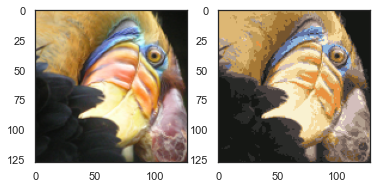

In [109]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(pic)
ax[1].imshow(compressed_pic)
plt.show()

### 2. Principal component analysis（主成分分析）

PCA是在数据集中找到“主成分”或最大方差方向的线性变换。 它可以用于降维。
在本练习中，我们将实现PCA应用于一个简单的二维数据集，以了解它是如何工作的。
我们从首先加载和可视化数据集开始。

In [110]:
data = loadmat('data/ex7data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Mon Nov 14 22:41:44 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[3.38156267, 3.38911268],
        [4.52787538, 5.8541781 ],
        [2.65568187, 4.41199472],
        [2.76523467, 3.71541365],
        [2.84656011, 4.17550645],
        [3.89067196, 6.48838087],
        [3.47580524, 3.63284876],
        [5.91129845, 6.68076853],
        [3.92889397, 5.09844661],
        [4.56183537, 5.62329929],
        [4.57407171, 5.39765069],
        [4.37173356, 5.46116549],
        [4.19169388, 4.95469359],
        [5.24408518, 4.66148767],
        [2.8358402 , 3.76801716],
        [5.63526969, 6.31211438],
        [4.68632968, 5.6652411 ],
        [2.85051337, 4.62645627],
        [5.1101573 , 7.36319662],
        [5.18256377, 4.64650909],
        [5.70732809, 6.68103995],
        [3.57968458, 4.80278074],
        [5.63937773, 6.12043594],
        [4.26346851, 4.68942896],
        [2.53651693, 3.88449078],
      

(50, 2)


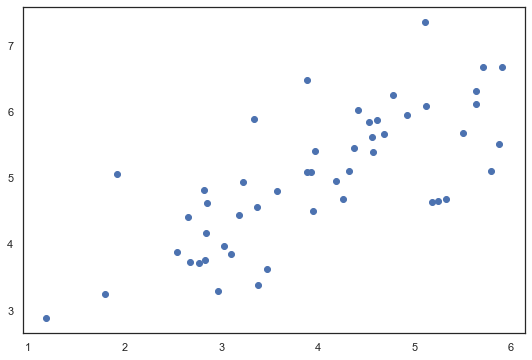

In [111]:
X = data['X']
print(X.shape)
fig, ax = plt.subplots(figsize=(9,6))
ax.scatter(X[:, 0], X[:, 1])
plt.show()

PCA的算法相当简单。 在确保数据被归一化之后，输出仅仅是原始数据的协方差矩阵的奇异值分解。
请实现PCA算法。

In [112]:
def pca(X):
    # normalize the features
    # YOUR_CODE_BEGIN, 请补充一行代码
    mu = np.mean(X, axis=0)
    sigma = np.std(X, axis=0)
    X = (X - mu) / sigma
    # YOUR_CODE_END
    
    # compute the covariance matrix
    X = np.matrix(X)
    # YOUR_CODE_BEGIN, 请补充一行代码
    cov = X.T @ X / len(X)
    # YOUR_CODE_END
    
    # perform SVD
    # YOUR_CODE_BEGIN, 请补充一行代码
    U, S, V = np.linalg.svd(cov)
    # YOUR_CODE_END
    
    return U, S, V

In [113]:
U, S, V = pca(X)
U, S, V

(matrix([[-0.70710678, -0.70710678],
         [-0.70710678,  0.70710678]]),
 array([1.73553038, 0.26446962]),
 matrix([[-0.70710678, -0.70710678],
         [-0.70710678,  0.70710678]]))

现在我们有主成分（矩阵U），我们可以用这些来将原始数据投影到一个较低维的空间中。
对于这个任务，我们将实现一个投影函数，仅选择顶部k个分量，从而有效地减少了维数。

In [114]:
def project_data(X, U, k):
    U_reduced = U[:,:k]
    return np.dot(X, U_reduced)

In [115]:
Z = project_data(X, U, 1)
Z
print(Z.shape)

(50, 1)


我们也可以通过反向转换步骤来恢复原始数据，请实现这个函数。

In [116]:
def recover_data(Z, U, k):
    # YOUR_CODE_BEGIN, 请补充一行代码
    U_reduced = U[:,:k]
    # YOUR_CODE_END
    
    # YOUR_CODE_BEGIN, 请补充一行代码
    return Z @ U_reduced.T
    # YOUR_CODE_END

In [117]:
X_recovered = recover_data(Z, U, 1)
X_recovered

matrix([[3.38533768, 3.38533768],
        [5.19102674, 5.19102674],
        [3.53383829, 3.53383829],
        [3.24032416, 3.24032416],
        [3.51103328, 3.51103328],
        [5.18952641, 5.18952641],
        [3.554327  , 3.554327  ],
        [6.29603349, 6.29603349],
        [4.51367029, 4.51367029],
        [5.09256733, 5.09256733],
        [4.9858612 , 4.9858612 ],
        [4.91644952, 4.91644952],
        [4.57319373, 4.57319373],
        [4.95278642, 4.95278642],
        [3.30192868, 3.30192868],
        [5.97369204, 5.97369204],
        [5.17578539, 5.17578539],
        [3.73848482, 3.73848482],
        [6.23667696, 6.23667696],
        [4.91453643, 4.91453643],
        [6.19418402, 6.19418402],
        [4.19123266, 4.19123266],
        [5.87990684, 5.87990684],
        [4.47644874, 4.47644874],
        [3.21050385, 3.21050385],
        [4.08319244, 4.08319244],
        [5.44225386, 5.44225386],
        [5.4506754 , 5.4506754 ],
        [3.81790296, 3.81790296],
        [4.494

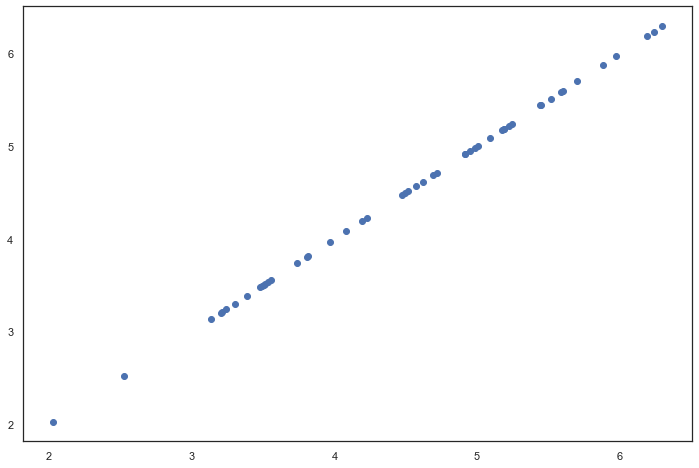

In [118]:
fig, ax = plt.subplots(figsize=(12,8))
ax.scatter(list(X_recovered[:, 0]), list(X_recovered[:, 1]))
plt.show()

我们看到，第一主成分的投影轴基本上是数据集中的对角线。当我们将数据减少到仅有一个维度时，我们失去了该对角线周围的变化，所以在我们的恢复数据中，一切都沿着该对角线。

我们在此练习中的最后一个任务是将PCA应用于人脸图像。通过使用相同的降维技术，我们可以使用比原始图像少得多的数据来捕获图像的“本质”。

In [119]:
faces = loadmat('data/ex7faces.mat')
X = faces['X']
X.shape

(5000, 1024)

In [120]:
def plot_n_image(X, n):
    """ plot first n images
    n has to be a square number
    """
    pic_size = int(np.sqrt(X.shape[1]))
    grid_size = int(np.sqrt(n))

    first_n_images = X[:n, :]

    fig, ax_array = plt.subplots(nrows=grid_size, ncols=grid_size,
                                    sharey=True, sharex=True, figsize=(8, 8))

    for r in range(grid_size):
        for c in range(grid_size):
            ax_array[r, c].imshow(first_n_images[grid_size * r + c].reshape((pic_size, pic_size)))
            plt.xticks(np.array([]))
            plt.yticks(np.array([]))


上述函数用来显示前n张人脸图像，你可以使用这个函数查看一下都有哪些人脸图像，选择一个你喜欢的进行接下来的练习，:)
有条件的同学可以尝试替换成自己的大头照进行下面的测试。

In [121]:
face = np.reshape(X[30,:], (32, 32))

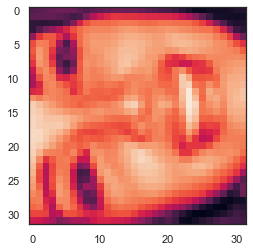

In [122]:
plt.imshow(face)
plt.show()

看起来很糟糕，马赛克效果比较明显吧。这些是只有32 x 32灰度的图像。
我们的下一步是在面数据集上运行PCA，并取得前100个主要特征。

In [123]:
U, S, V = pca(X)
Z = project_data(X, U, 100)

现在我们可以尝试恢复原来的结构并再次渲染。

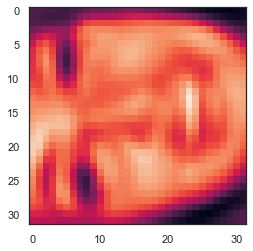

In [124]:
X_recovered = recover_data(Z, U, 100)
face = np.reshape(X_recovered[30,:], (32, 32))
plt.imshow(face)
plt.show()

请注意，我们失去了一些细节，尽管没有像您预期的维度数量减少10倍，但总得显示效果还不错。